**Ai Project Report By Christian Gauthier**

*Following the project workflow of Chollet* 

**Introduction**

In this investigation I will be looking to create a deep learning model to perform linear regression trained on a dataset of wine quality created by Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV). In this dataset is 1599 labelled red wines of the Portuguese "Vinho Verde" wine with 11 different input variables and one output variable being quality, the value that the model will predict. The dataset has the following variables:
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide 
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol
12. quality (output)


The dataset contains only quantifiable data which will allow for me to perform statistical analysis of the data to determine the most important input factors that relate to the output (quality).

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
import io

#loading external datasets
url = 'https://raw.githubusercontent.com/thestianchris/RedRedWine-QualityChecker/main/winequality-red.csv'
df = pd.read_csv(url)

df.sample() #show a sample data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
323,10.3,0.59,0.42,2.8,0.09,35.0,73.0,0.999,3.28,0.7,9.5,6


<AxesSubplot:>

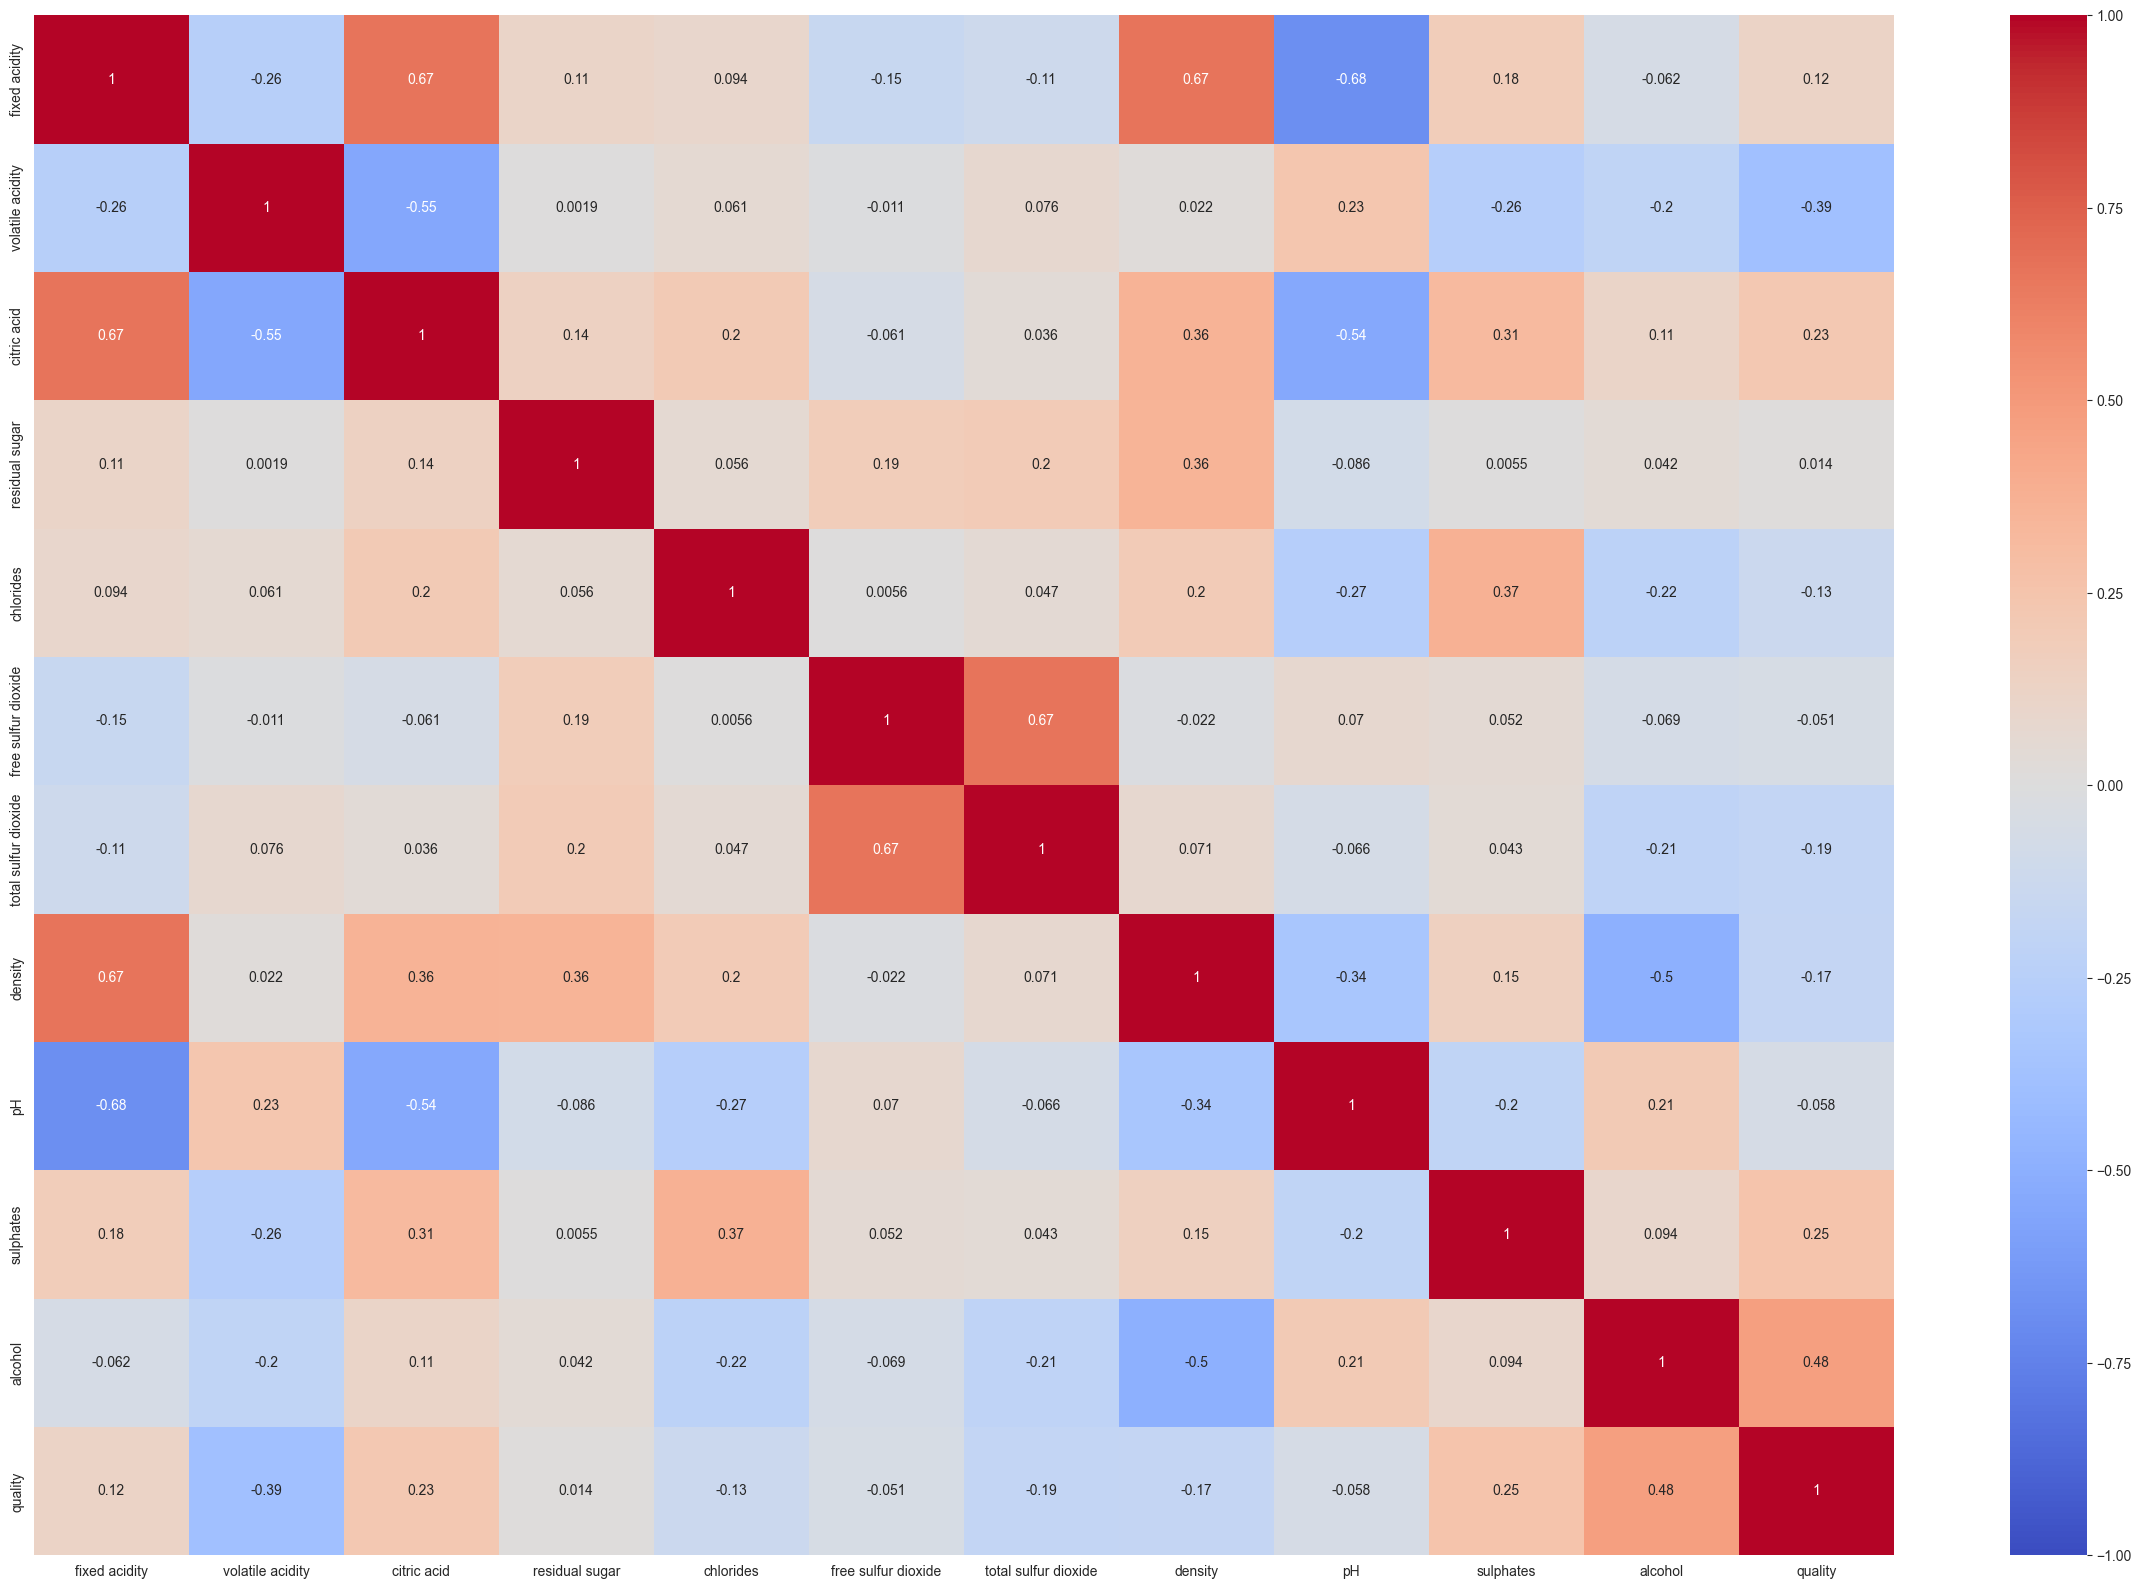

In [ ]:
df.describe() #return a description of the dataframe 

plt.figure(figsize=(30,20)) #create figure
sb.heatmap(df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap

**The Data**
From the heatmap we can see that some input variables are more important towards the overall quality of the wine, these include:
Alcohol (0.46), Volatile Acidity (-0.39), Sulphates (0.25), Citric Acid (0.23), Total Sulfur Dioxide (-0.19), Density (-0.17), Chlorides (-0.13) and Fixed Acidity (0.12)
All other inputs have a minimal amount of effect on the quality.

<AxesSubplot:>

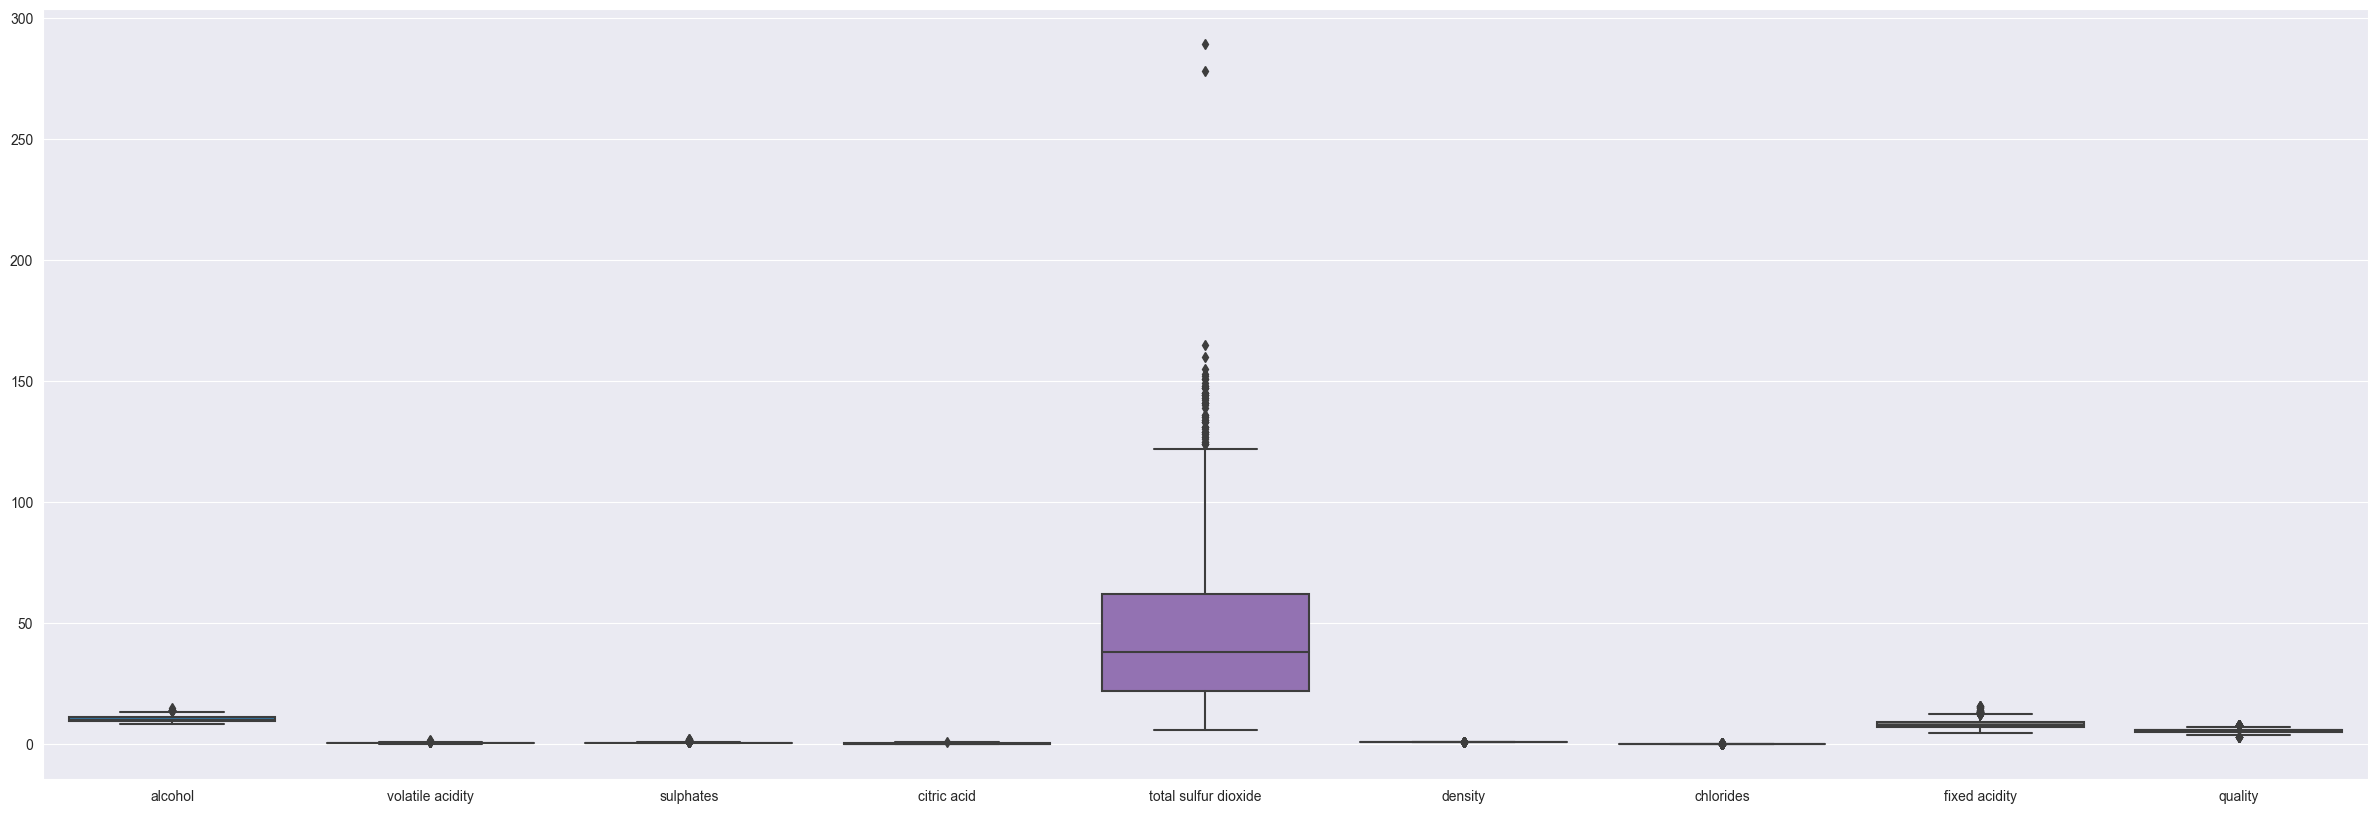

In [ ]:
plt.figure(figsize=(30,10))
important = df[['alcohol','volatile acidity','sulphates','citric acid','total sulfur dioxide','density','chlorides','fixed acidity','quality']]
sb.boxplot(data=important)

**Methodology**

For this data I will be creating a linear regression model along with using K-fold validation due to the smaller size of the dataset. I will use the top 8 performing input variables for the prediction model as the others are insignificant. I will standardize the data to restrict the values distribution around zero along with the standard deviation being a value of one.

To measure success our metric will be using mean squared error (MSE) and mean absolute error (MAE). The MAE will measure the average distance between the real data and the predicted data, MSE will measure the squared average distance between the real data and predicted data however large errors are better detected compared to MAE that won't find these larger errors.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#make new dataframe of the important variables
important_data = df[['alcohol','volatile acidity','sulphates','citric acid','total sulfur dioxide','density','chlorides','fixed acidity']]
labels = df['quality']
#Splitting the data into testing and training using an 80% and 20% ratio
train = important_data.values #set the inputs as all columns except the quality as train
test = labels.values #quality label

train_data, test_data, train_label, test_label = train_test_split(train,test, test_size = 0.8, random_state = 0)

#standardize the data
scale= StandardScaler()
train_data = scale.fit_transform(train_data)
test_data = scale.fit_transform(test_data)

print(train_data)

[[-0.26829722 -1.15833393 -0.25135402 ... -0.48132233 -0.41878899
  -0.61106758]
 [-1.1852988   1.98211593 -0.54795797 ... -0.0351188  -0.26600135
  -0.61106758]
 [ 2.68648564  0.33204905 -1.4872038  ... -2.08553029 -0.60977353
  -0.20664734]
 ...
 [-0.87963161  0.17236516  0.09468391 ... -0.00855906 -0.17050908
  -0.26442166]
 [ 2.38081845 -0.35991448  0.04524992 ...  2.82270863 -0.05591836
   2.6820687 ]
 [-0.98152067  2.35471167 -0.9434299  ...  0.6448104  -0.18960754
   0.83329044]]


**Building The Model**
Now that the data is ready to be used, it's time for the model to be made.
To start I will create the model to have a single hidden layer with a relu activation function to give positive values.
A RMSprop optimizer is also being added to the model so that learning rate and momentum can be adjusted later on.

I will also be outputting the range, mean and standard deviation of the test data as a comparison metric to be used for testing validation.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(clear=True): #Provided in workbook 4.3
    if clear:
        tf.keras.backend.clear_session()
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',
              input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(1))
            # ↑ -------------------------------------------
    model.compile(
        optimizer='rmsprop',
        loss='mse',            #
        metrics=['mae']
    )
    return model

test_targets_min, test_targets_max = test_label.min(), test_label.max()
test_targets_mean, test_targets_std = test_label.mean(), test_label.std()
#output our values
print(f"Range of test quality:, min: {test_targets_min} | max:  {test_targets_max}")
print(f"Mean of our test quality:  {test_targets_mean}")
print(f"STD of our test quality: {test_targets_std}")

Range of test quality:, min: 3 | max:  8
Mean of our test quality:  5.62890625
STD of our test quality: 0.8094801904376274


**Testing Untrained Model**
With our rough values to go against for validation, it's time to see how an untrained model will do against a mean mae prediction

In [ ]:
#Provided in workbook 4.3
#calculating the mean mae
mean_prediction = []
test_targets_mean = test_label.mean()
for test in test_label:
    mean_prediction.append(np.abs(test - test_targets_mean))  # MAE using the mean of our test dataset
mean_prediction_mae = np.array(mean_prediction).mean()
print(f"Predicting the mean of our test_set: {test_targets_mean}")
print(f"MAE: {mean_prediction_mae}")

#testing on untrained model
test_mse_score, test_mae_score = build_model().evaluate(test_data, test_label, verbose=0)
test_mse_score_sqrt = np.sqrt(test_mse_score)
msg =  f"MSE: {test_mse_score}, sqrt: {test_mse_score_sqrt} "
msg += f"MAE: {test_mae_score})"
print("Model Predictions:")
print(msg)

Predicting the mean of our test_set: 5.62890625
MAE: 0.682366943359375
Model Predictions:
MSE: 30.7305850982666, sqrt: 5.543517394061879 MAE: 5.466217517852783)


**Compare**
The mean prediction for the MAE came to 0.6824 whilst the untrained model produced a value of 5.2239
As we can see the model needs to fix itself up a bit, to do this we will implement the K-folding along with using 50 epochs (how many times the model will work through the dataset) along with a batch size of 16 (how many samples within the dataset to work through). A smaller initial batch size is being used so that adjustments can be made, and later increased to have better performance. For the K-fold, I will be using 3 splits in the data

Within the method below, the train data is split into validation so that the test data can remain unseen to the model.

In [ ]:
#Provided in workbook 4.3
all_scores = []
def run_Kfold(K,epochnum,batchsize):
    for i in range(K):
        num_val_samples = len(train_data) // K
        print(f"Processing fold {i+1}")
        #Create validation data from each partitions of the data
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data, val_label = train_data[a : b], train_label[a : b]

        #train data from all the other partitions
        partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
        partial_train_label = np.concatenate([train_label[:a], train_label[b:]], axis=0)

        #create model
        model = build_model()

        #train model
        model.fit(partial_train_data, partial_train_label,  # 4. Train the model
              epochs=epochnum, batch_size=batchsize, verbose=0)

        #evaluate on validation data
        val_mse, val_mae = model.evaluate(val_data, val_label, verbose=0)
        all_scores.append(val_mae)

run_Kfold(3,50,16)

def kowalski(): #The name of the smart penguin from madagascar movie
    '''
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣶⠛⠛⠛⠛⠷⣶⣤⣀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⠟⠁⠈⢳⡀⢀⣠⣴⡿⠿⠛⠁⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡞⠁⠀⠀⠀⠀⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡾⠀⢀⣠⣤⣄⢸⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⠁⠀⣾⠋⠈⠹⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢸⡏⠀⠀⢻⡆⠀⠀⢹⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⢸⡇⠀⠀⠈⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⢸⣇⠀⠀⠀⣿⣿⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⢸⣿⠀⠀⢠⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠸⣷⠀⠀⠈⣿⠀⢀⣾⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡀⠀⠀⠻⢶⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⢀⣤⡾⠃⠀⠀⠀⠈⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢠⣶⣯⣤⣤⣤⣤⡴⠶⠶⣼⣿⣿⣷⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀
    '''
    print(f"Validation MAE scores for each fold:")
    for score in all_scores:
        print(f"{score:.4f}")

    min_score, max_score = min(all_scores), max(all_scores)
    print(f"Validation MAE scores range from:")
    print(f"{min_score:.4f} to {max_score:.4f}")

kowalski()

Processing fold 1


C:\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Processing fold 2
Processing fold 3
Validation MAE scores for each fold:
0.7013
0.5875
0.6244
Validation MAE scores range from:
0.5875 to 0.7013


**First Model Evaluation**

From the first model we can see that the MAE scores are better than the prediction that was done before, with the best value from the model being between 0.4 and 0.5548 whilst the prediction was 0.6824
This is a good start, and from here we can start to further tinker with hyperparameters.

For the next model, I will apply learning rate and momentum onto the RMSprop optimizer along with adding another hidden layer in the model.


In [ ]:
from tensorflow.keras import optimizers
def build_model(clear=True): #Provided in workbook 4.3
    if clear:
        tf.keras.backend.clear_session()
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',
              input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=optimizers.RMSprop(lr=0.0015, momentum=0.09), #using random values for now
        loss='mse',
        metrics=['mae']
    )
    return model

all_scores = [] #reset the MAE scores
run_Kfold(3,50,16)
kowalski()



Processing fold 1


C:\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Processing fold 2
Processing fold 3
Validation MAE scores for each fold:
0.6137
0.5669
0.5477
Validation MAE scores range from:
0.5477 to 0.6137


**Second Model Evaluation**

**Optimizer Adjustment**
RUN: LEARNING RATE; MOMENTUM; BEST MAE;
1: 0.001, 0.05, 0.5435
2: 0.001, 0.07, 0.4850
3: 0.001, 0.09, 0.5132
4: 0.001, 0.11, 0.5351
5: 0.003, 0.09, 0.5641
6: 0.002, 0.09, 0.5083
7: 0.0015, 0.09, 0.4978
8: 0.0015, 0.08, 0.5132
9: 0.0015, 0.0075, 0.5899
10: 0.0009, 0.065, 0.5864
11: 0.0015, 0.09, 0.5243

From tinkering with the learning rate and momentum, I have decided to use the values of 0.0015 and 0.09
Now I will record results for changing the amount of units per hidden layer:

**Unit Adjustment**
Run; First Layer Units; Second Layer Units; BEST MAE;
1:32,64,0.5199
2:32,64,0.5347
3:64,64,0.5018
4:64,64,0.5016
5:64,128,0.5782
6:128,64,0.5818
7:128,128,0.6024

From these results it can be seen that the best combination is 64,64.

In the next model adjustment I will be increasing the epoch number to 500 and the batch size to 64.
I will also be testing different values of K to split the data into partitions

In [ ]:
all_scores = [] #reset the MAE scores
run_Kfold(4,500,128)
kowalski()

Processing fold 1


C:\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Processing fold 2
Processing fold 3
Processing fold 4
Validation MAE scores for each fold:
0.5363
0.5233
0.5328
0.6493
Validation MAE scores range from:
0.5233 to 0.6493


**Third Model Evaluation**

Run; Kfolds; Epochs; Batch size; Best MAE;
1:3,250,32,0.5738
2:3,250,16,0.5923
3:3,500,64,0.5747
4:4,300,16,0.5694
5:4,500,64,0.5287
6:5,500,64,0.6072
7:4,750,128,0.5829
8:4,500,128,0.4908
9:4,500,250,0.5555
10:4,500,128,0.5123

I found the best results to be for 4 kfolds, 500 epochs and a batch size of 128 to produce the lowest MAE of 0.4908 so for the rest of model production I shall be using these values.
To further progress the model, I will be using a callback to get a better understanding of what the model is doing, and later run the model from the best epoch.

Processing fold 1
| epoch: 1/500

C:\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


\ epoch: 500/500
Processing fold 2
\ epoch: 500/500
Processing fold 3
\ epoch: 500/500
Processing fold 4
\ epoch: 500/500


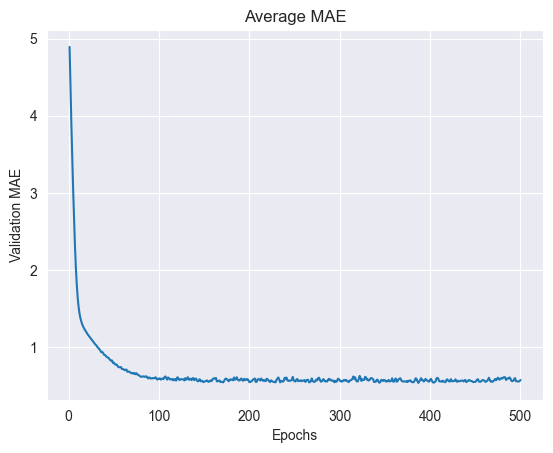

In [ ]:
#Provided in workbook 4.3
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):                                            # by passing epochs at initialization
        super(tf.keras.callbacks.Callback, self).__init__()                # I can use this as our total in on_epoch_begin
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):                            # run at the start of each epoch
        c = ['|', '/', '-', '\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")  # run at the very end of training
    def on_train_end(self, logs=None):
        print()

all_mae_histories = [] #store the mae history
#Provided in workbook 4.3
def run_Kfold(K,epochnum,batchsize):
    for i in range(K):
        num_val_samples = len(train_data) // K
        print(f"Processing fold {i+1}")
        #Create validation data from each partitions of the data
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data, val_label = train_data[a : b], train_label[a : b]

        #train data from all the other partitions
        partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
        partial_train_label = np.concatenate([train_label[:a], train_label[b:]], axis=0)

        #create model
        model = build_model()

        #train model
        history = model.fit(partial_train_data, partial_train_label, # 4. Train the model (in silent mode, verbose=0)
                        epochs=epochnum, batch_size=batchsize, verbose=0,
                        validation_data=(val_data, val_label),
                        callbacks=[CustomCallback(epochnum)])

        #evaluate
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)

run_Kfold(4,500,128)
average_mae_history = np.array(all_mae_histories).mean(axis=0) #get the mean of the mae in all Kfolds
#plot a nice pretty graph
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Average MAE")
plt.show()

**THE DATA**

Looking at the graph we can see that the validation MAE quickly drops from just under 5 towards the 0.5 level at around 80 epochs where it then straightens off and begins to make small jumps.
To fix this issue, we can use the history values of the MAE to determine the best epoch for the model to run from, which should provide the best MAE overall.
By creating a smooth curve that causes each of the data points to use a weighted sum of itself and previous datapoint, we can get a better view of what is happening and the epoch that it takes place.


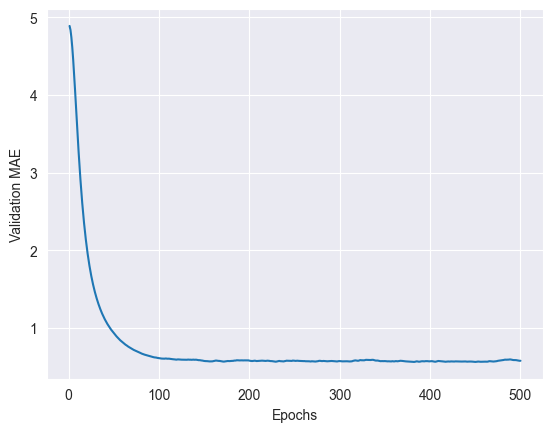

Best epoch is:  449


In [ ]:
#Provided in workbook 4.3
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history)
#wow so smooth!
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print('Best epoch is: ', np.argmin(smooth_mae_history))

**Epoch Time**

From this run, the best epoch is 449, so now the model will be run on the full training dataset until the last epoch where the best MAE is given.

In [ ]:
#Provided in workbook 4.3
model = build_model()
model.fit(
    train_data, # ← WHOLE TRAINING DATA
    train_label,
           # ↓ EPOCH WITH LOWEST MAE ------
    epochs = np.argmin(average_mae_history),

    batch_size = 100
)

Epoch 1/386


C:\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 0s 2ms/step - loss: 31.3131 - mae: 5.5132
Epoch 2/386
4/4 [==============================] - 0s 1ms/step - loss: 22.5474 - mae: 4.6246
Epoch 3/386
4/4 [==============================] - 0s 2ms/step - loss: 16.0560 - mae: 3.8184
Epoch 4/386
4/4 [==============================] - 0s 1ms/step - loss: 11.0252 - mae: 3.0478
Epoch 5/386
4/4 [==============================] - 0s 1ms/step - loss: 7.4674 - mae: 2.3965
Epoch 6/386
4/4 [==============================] - 0s 1ms/step - loss: 5.2053 - mae: 1.9227
Epoch 7/386
4/4 [==============================] - 0s 1ms/step - loss: 4.0979 - mae: 1.6632
Epoch 8/386
4/4 [==============================] - 0s 1ms/step - loss: 3.2222 - mae: 1.4577
Epoch 9/386
4/4 [==============================] - 0s 1ms/step - loss: 2.7525 - mae: 1.3205
Epoch 10/386
4/4 [==============================] - 0s 1ms/step - loss: 2.4464 - mae: 1.2524
Epoch 11/386
4/4 [==============================] - 0s 1ms/step - loss: 2.2286 - mae: 1

In this run, the loss was 0.0795 and the MAE 0.2165, a significant increase.
Finally, it's time to test against the test data

In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_label)
predictions = model.predict(test_data)
counter = 0
for i in range(30):
    print(i, '\t', predictions[i].round(), '\t', test_label[i], '\t', (predictions[i].round() == test_label[i]))
    if predictions[i].round() == test_label[i]:
        counter += 1
print(f"Total Correct  {counter}")

40/40 [==============================] - 0s 667us/step
0 	 [5.] 	 6 	 [False]
1 	 [5.] 	 5 	 [ True]
2 	 [7.] 	 7 	 [ True]
3 	 [5.] 	 6 	 [False]
4 	 [7.] 	 5 	 [False]
5 	 [5.] 	 6 	 [False]
6 	 [5.] 	 5 	 [ True]
7 	 [6.] 	 6 	 [ True]
8 	 [5.] 	 4 	 [False]
9 	 [5.] 	 5 	 [ True]
10 	 [5.] 	 5 	 [ True]
11 	 [6.] 	 5 	 [False]
12 	 [5.] 	 6 	 [False]
13 	 [5.] 	 5 	 [ True]
14 	 [5.] 	 6 	 [False]
15 	 [7.] 	 6 	 [False]
16 	 [7.] 	 7 	 [ True]
17 	 [5.] 	 5 	 [ True]
18 	 [5.] 	 5 	 [ True]
19 	 [5.] 	 4 	 [False]
20 	 [6.] 	 7 	 [False]
21 	 [5.] 	 6 	 [False]
22 	 [6.] 	 6 	 [ True]
23 	 [5.] 	 4 	 [False]
24 	 [6.] 	 6 	 [ True]
25 	 [5.] 	 5 	 [ True]
26 	 [5.] 	 5 	 [ True]
27 	 [7.] 	 7 	 [ True]
28 	 [5.] 	 5 	 [ True]
29 	 [6.] 	 6 	 [ True]
Total Correct  17


**Conclusion**

 The final result on of testing the model against unseen data produces an MAE result of 0.5734, whilst slightly larger than the final model training amount of 0.2165.
 The earlier predicted MAE from averaging gave the value 0.6824, so on comparison, the final MAE beats the preset validation levels, which can be considered a success!

Overall the model will successfully predict the quality around 55%, however I believe that this number could be alot better with further tweaks of the model or by overall creating a new type of regression model such as a regression tree based design that uses cross validation against branches to obtain more accurate predictions. The hyperparameter adjustments made to this linear regression model showed improvements over the seperate iterations, as seen by the final MAE prediction, but could most certainly be further worked upon to produce a better final testing MAE result.

The dataset that was used has a sister dataset containing white wine information, however due to some issues with the data was not used for this model creation, in further advancements I would look to try and adapt the data to fit the quality of the dataset used for the red wine, this would give further datapoints to train on, and hopefully produce a better result. The smaller size of the dataset could be a reason for the final MAE, despite the use of K-folding. Another point to make is that many of the quality values in the dataset are very close together, being centered around 4/5/6 and whilst the maximum value could be 10, no data has any values above 9 or below 3.

Thanks !

**References:**
*   Chollet, F. (2018), *Deep Learning with Python*, Shelter Island: Manning.
*   Wenger, J. (2021), *Artificial Intellience Module: Lecture Notes*, London: Goldsmiths,University of London.
*   Paulo Cortez, (Univ. Minho) (2009), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV)
